# CS 135 day07: Binary Classifier Basics

# Objectives

* Learn how to use *probabilistic* binary classifiers in sklearn
* * Call `fit` to train them on provided labeled dataset
* * Call `predict_proba` to get probabilistic predictions (will give you multiple columns, one per possible label)
* * * use `predict_proba(...)[:,1]` to get just the probabilities of the positive class
* * Call `predict` to get hard binary decisions

* See tradeoffs among two common classifiers
* * Logistic Regression
* * K Nearest Neighbors

# Outline
* [Part 1: Binary classification with Logistic Regression on 1-dim. toy example](#part1)
* [Part 2: Binary classification with K-NN on 1-dim. toy example](#part2)
* [Part 3: Confusion matrices and accuracy](#part3)
* [Part 4 (Bonus): Visualizing decision boundaries of Logistic Regression on 2-dim. features](#part4)
* [Part 5 (Bonus): Visualizing decision boundaries of K-NN on 2-dim. features](#part5)

We expect you'll get through the first 3 parts during this lab.

# Takeaways

* We need to carefully index the output of `predict_proba` to be sure we have the proba we are looking for
* Logistic Regression produces linear decision boundaries (as function of features)
* K-nearest neighbors produces piecewise constant decision boundaries (as function of features)


In [ ]:
import numpy as np

In [ ]:
import sklearn.linear_model
import sklearn.neighbors

In [ ]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setting up a simple classification task with 1-dim features

Let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [ ]:
# We generated this training set for you.

N = 12

x_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_N1 = x_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_N = np.asarray([0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

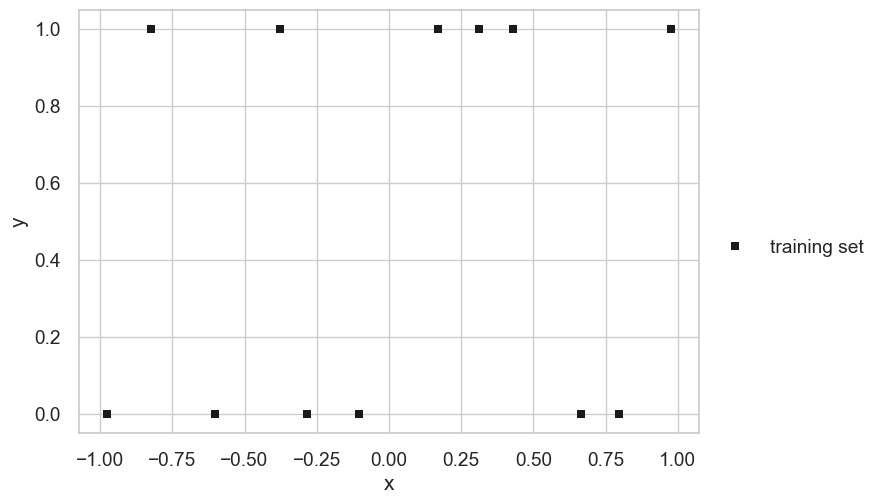

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

### Make validation set for 1-d toy example

In [ ]:
def make_dataset(n_examples=10, seed=101, flip_fraction=0.15):
    N = int(n_examples)
    prng = np.random.RandomState(seed)

    # Make x values between -1 and 1, roughly evenly spaced
    x_N = np.linspace(-1, 1, N) + 0.05 * prng.randn(N)

    # Make y values such that broadly, the true function says:
    # y_n = 1  if x_n > 0 
    # y_n = 0  otherwise
    y_N = np.asarray(x_N > 0, dtype=np.int32)

    # flip a small percentage of the values
    chosen_ids = prng.permutation(np.arange(N))[:int(np.floor(flip_fraction * N))]
    y_N[chosen_ids] = 1 - y_N[chosen_ids]
    return x_N.reshape((N,1)), y_N

In [ ]:
M = 100
x_va_M1, y_va_M = make_dataset(n_examples=M, seed=201)

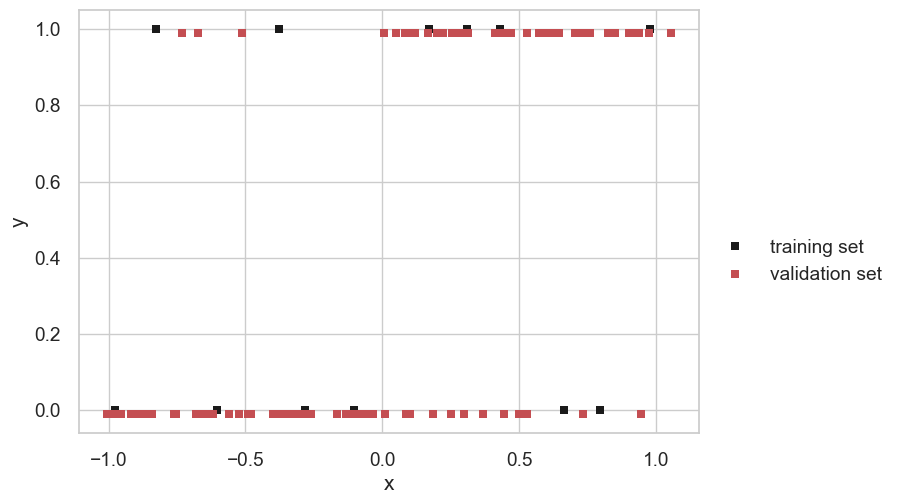

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.plot(x_va_M1, y_va_M - 0.01, 'rs', label='validation set'); # add small vertical offset so you can see

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part1"></a>

# Part 1: Train a logistic regression model for F=1 data

Here, we'll fit a Logistic Regression probabilistic classifier to the above 1-dim. feature dataset.

Remember the training objective for Logistic Regression is

$$
w^*, b^* \gets \mathrm{arg\,min}_{w \in \mathbb{R}, b \in \mathbb{R}} ~~ C \sum_{n=1}^N \text{bce}( y_n, \sigma(w x + b) ) + w^2
$$

In [ ]:
# We'll use C = 10000.0 for now. 
# You could select it like any hyperparameter on validation data.

lr = sklearn.linear_model.LogisticRegression(C=10000.0, penalty='l2');

In [ ]:
lr.fit(x_N1, y_N)

LogisticRegression(C=10000.0)

Just like linear regression, logistic regression has two learnable parameters for 1-dim features:

* a weight coefficient "coef_"
* an intercept coefficient "intercept_"

Peek at the learned weights and intercept

In [ ]:
lr.coef_

array([[0.52990026]])

In [ ]:
lr.intercept_

array([-0.00801258])

### Make probabilistic predictions with predict_proba

Remember, `predict_proba()` returns the probabilities of ALL possible labels: 0 and 1

There will be two columns, one for each label.

The first column is for the class corresponding to binary label 0.
The second column is for the class corresponding to binary label 1.

In [ ]:
yproba_N2 = lr.predict_proba(x_N1)
print("yproba_N2")
print("Shape: " + str(yproba_N2.shape))
print(yproba_N2)

yproba_N2
Shape: (12, 2)
[[0.62823803 0.37176197]
 [0.6094927  0.3905073 ]
 [0.58116129 0.41883871]
 [0.5518912  0.4481088 ]
 [0.53954331 0.46045669]
 [0.51551062 0.48448938]
 [0.47962615 0.52037385]
 [0.4608835  0.5391165 ]
 [0.44512828 0.55487172]
 [0.41500535 0.58499465]
 [0.39813114 0.60186886]
 [0.3753881  0.6246119 ]]


To get only the probabilities for the positive class (y=1), grab the *second* column (the column with *index 1*)

In [ ]:
yproba1_N = lr.predict_proba(x_N1)[:,1]

print("yproba1_N")
print("Shape: " + str(yproba1_N.shape))
print(yproba1_N)

yproba1_N
Shape: (12,)
[0.37176197 0.3905073  0.41883871 0.4481088  0.46045669 0.48448938
 0.52037385 0.5391165  0.55487172 0.58499465 0.60186886 0.6246119 ]


### Exercise 1a: How would you calculate the probability of the "negative" class (label y=0)?

Remember, if there are only two possible events, $A$ and $B$, we can always say:

$p(A) + p(B) = 1$

In [ ]:
yproba0_N = np.zeros(N) # TODO compute yproba0_N from yproba1_N

### Make binary predictions with `predict`

Calling the function `lr.predict(...)` produces a binary value, either 0 or 1, for each of the N input examples

In [ ]:
yhat_N = lr.predict(x_N1)

print("yhat_N")
print("Shape: " + str(yhat_N.shape))
print(yhat_N)

yhat_N
Shape: (12,)
[0 0 0 0 0 0 1 1 1 1 1 1]


### Exercise 1b: Can you reproduce these "binary" predictions by thresholding yproba1 at 0.5?

By default, sklearn uses a threshold of 0.5.

Any probability of the positive event equal to or above 0.5 will be predicted as positive integer 1.
Otherwise, a 0 integer value will be predicted

In [ ]:
# TODO edit code below so its predictions match the result of lr.predict() above
# You can change a numpy binary array to an integer array using
# `np.asarray(bin_arr, dtype=np.int32)`
# If correct, your output should exactly equal [0 0 0 0 0 0 1 1 1 1 1 1]

my_yhat_N = yproba1_N > 0.0 # TODO fix me. Use threshold of 0.5 and cast to integer

print(my_yhat_N)

[ True  True  True  True  True  True  True  True  True  True  True  True]


### Plot: predicted probabilities vs. feature value

We can see that the predicted probabilities from Logistic Regression are *smooth* functions of input features.


In [ ]:
# Create dense grid of L input examples from -1.5 to 1.5
# so we can better understand the learned predictions
L = 101
dense_x_L1 = np.linspace(-1.5, 1.5, L).reshape((L,1))
yproba1_dense_L = lr.predict_proba(dense_x_L1)[:,1]

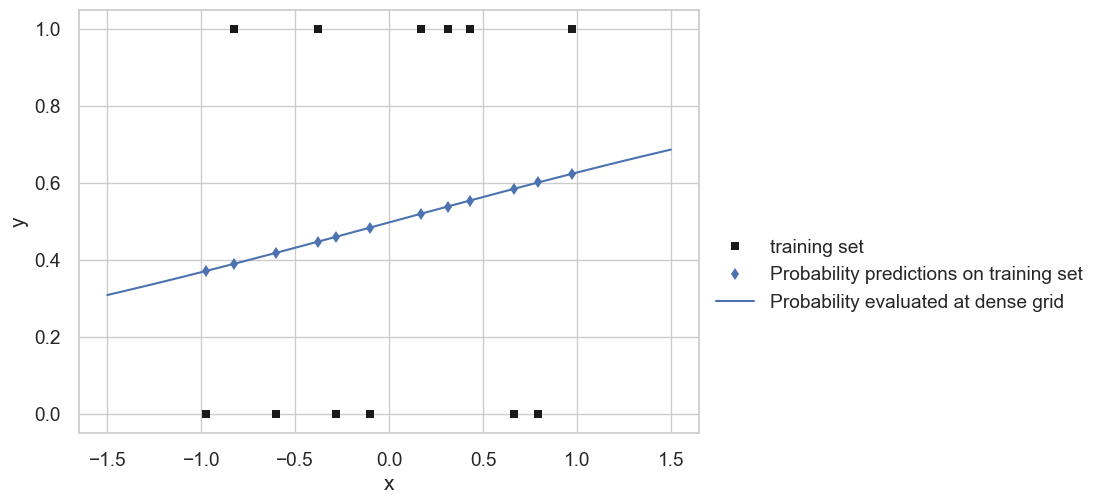

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.plot(x_N, yproba1_N, 'bd', label='Probability predictions on training set');
plt.plot(dense_x_L1, yproba1_dense_L, 'b-', label='Probability evaluated at dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

<a id="part2"></a>

# Part 2: Train a k-nearest neighbors model for F=1 data

Here, we'll fit a K Nearest probabilistic classifier to the above 1-dim. feature dataset.

In [ ]:
# We'll use K = 3 neighbors for now. You could select it like any hyperparameter on validation data.

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(x_N1, y_N)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_yproba1_N = knn.predict_proba(x_N1)[:,1]
print("knn_yproba1_N")
print("Shape: " + str(knn_yproba1_N.shape))
print(knn_yproba1_N)

knn_yproba1_N
Shape: (12,)
[0.33333333 0.33333333 0.66666667 0.33333333 0.33333333 0.33333333
 1.         1.         0.66666667 0.33333333 0.33333333 0.33333333]


### Plot predicted probabilities vs feature value

We'll again use the same dense grid of L inputs to understand the predicted probability function.

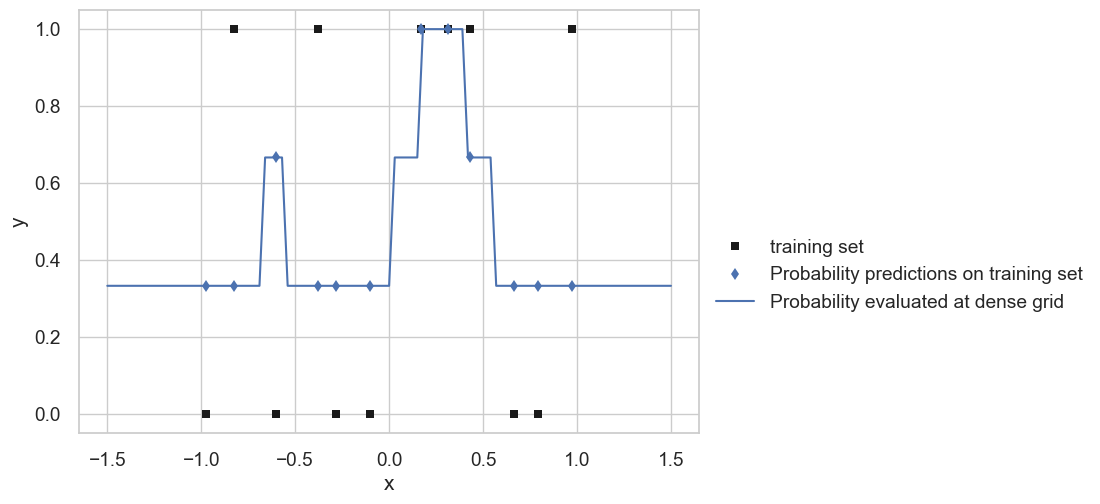

In [ ]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.plot(x_N, knn_yproba1_N, 'bd', label='Probability predictions on training set');
plt.plot(dense_x_L1, knn.predict_proba(dense_x_L1)[:,1], 'b-', label='Probability evaluated at dense grid')

plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

### Discussion 2a: What is happening at x = 0.05? What 3 neighbors are used to make the prediction?

### Discussion 2b: Why does the above plot have "piecewise constant" predicted probabilities?

<a id="part3"></a>

# Part 3: Computing confusion matrices on validation set

Remember, the order of the cells in a confusion matrix is like this diagram:

    | -- | -- |
    | TN | FP |
    | FN | TP |
    | -- | -- |

In [ ]:
lr_yhat_va_M = lr.predict(x_va_M1)
knn_yhat_va_M = knn.predict(x_va_M1)

In [ ]:
print("LR confusion:")
sklearn.metrics.confusion_matrix(y_va_M, lr_yhat_va_M)

LR confusion:


array([[47, 11],
       [ 4, 38]])

In [ ]:
print("3-NN confusion:")
sklearn.metrics.confusion_matrix(y_va_M, knn_yhat_va_M)

3-NN confusion:


array([[43, 15],
       [24, 18]])

### Exercise 3a: What is the accuracy of the LR classifier on validation set?

In [ ]:
# TODO compute using data from the printed confusion matrices above

### Exercise 3b: What is the accuracy of the KNN classifier on validation set?

In [ ]:
# TODO compute using data from the printed confusion matrices above

### Discussion 3c: Which classifier has better accuracy on the validation set? Does this match what you'd think from the pictures visualizing the predicted probability functions above?

In [ ]:
# TODO write your answer here, then discuss with your group

# Setup for Parts 4 - 5

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [ ]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([0, 0])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

## Create the dataset with 100 points per class

In [ ]:
x_N2, y_N = create_2d_dataset(N=100, noise_stddev=0.3)

## Define function to plot data as scatterpoints in 2d

In [ ]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

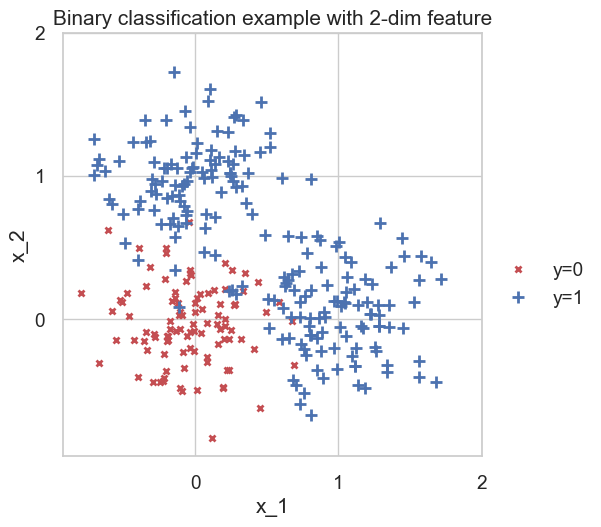

In [ ]:
plot_pretty_data_colored_by_labels(x_N2, y_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);
plt.title("Binary classification example with 2-dim feature");

### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [ ]:
def plot_pretty_probabilities_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

### Define function to visualize hard decisions made as threshold

You don't need to understand this in detail. Just a utility function you'll use below.

In [ ]:
def plot_pretty_decision_boundaries_for_clf(
        clf,
        threshold=0.5,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    yhat_M = yproba1_M >= threshold
    
    # Reshape the M probas into the GxH 2D field
    yhat_GH = np.reshape(yhat_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yhat_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

<a id="part5"></a>

<a id="part4"></a>

# Part 4: Visualization of KNN predictions as we vary K

### Figure:  KNN predicted proba (colors) over 2D plane of x1, x2 

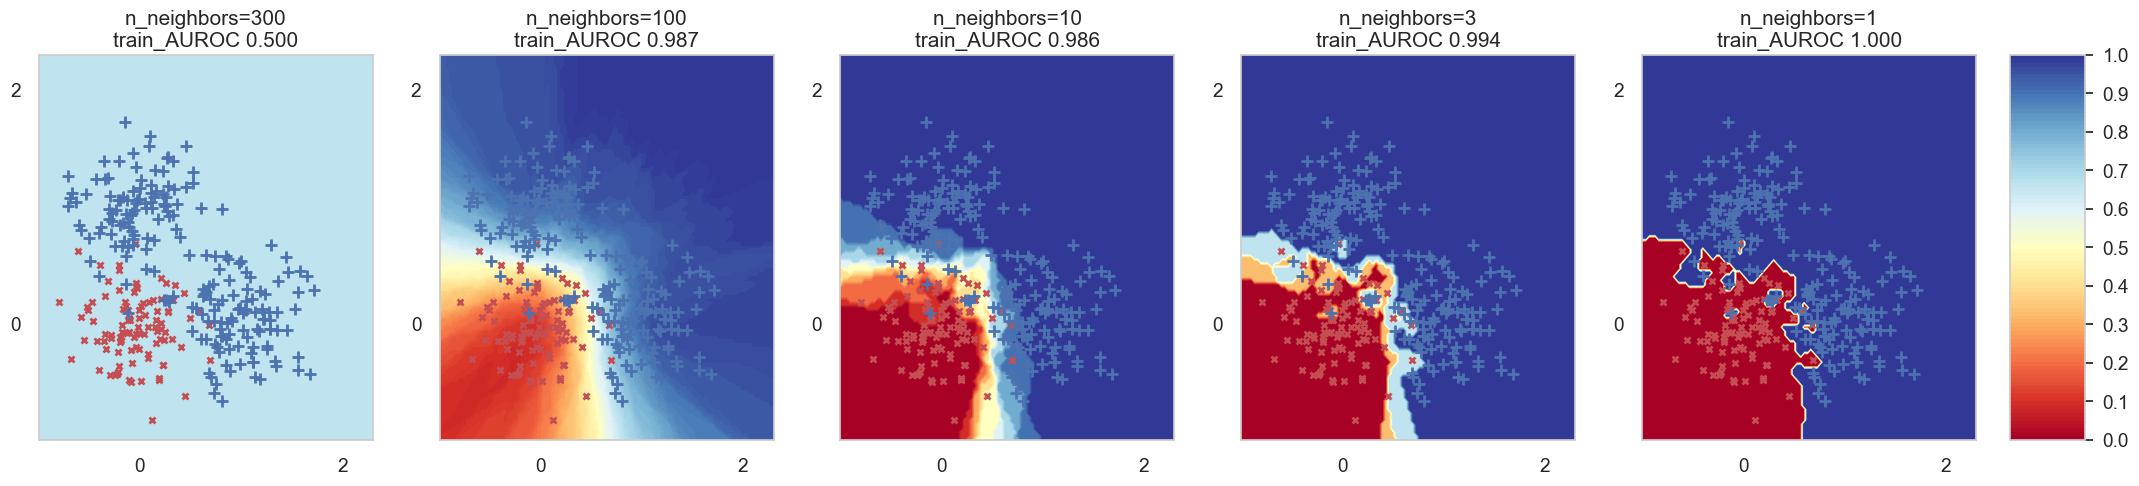

In [ ]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    auroc = sklearn.metrics.roc_auc_score(y_N, clf.predict_proba(x_N2)[:,1])

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d\ntrain_AUROC %.3f" % (n_neighbors, auroc))

## KNN: hard binary decisions (colors) over 2D plane of (x1, x2)

Using Threshold: 0.5

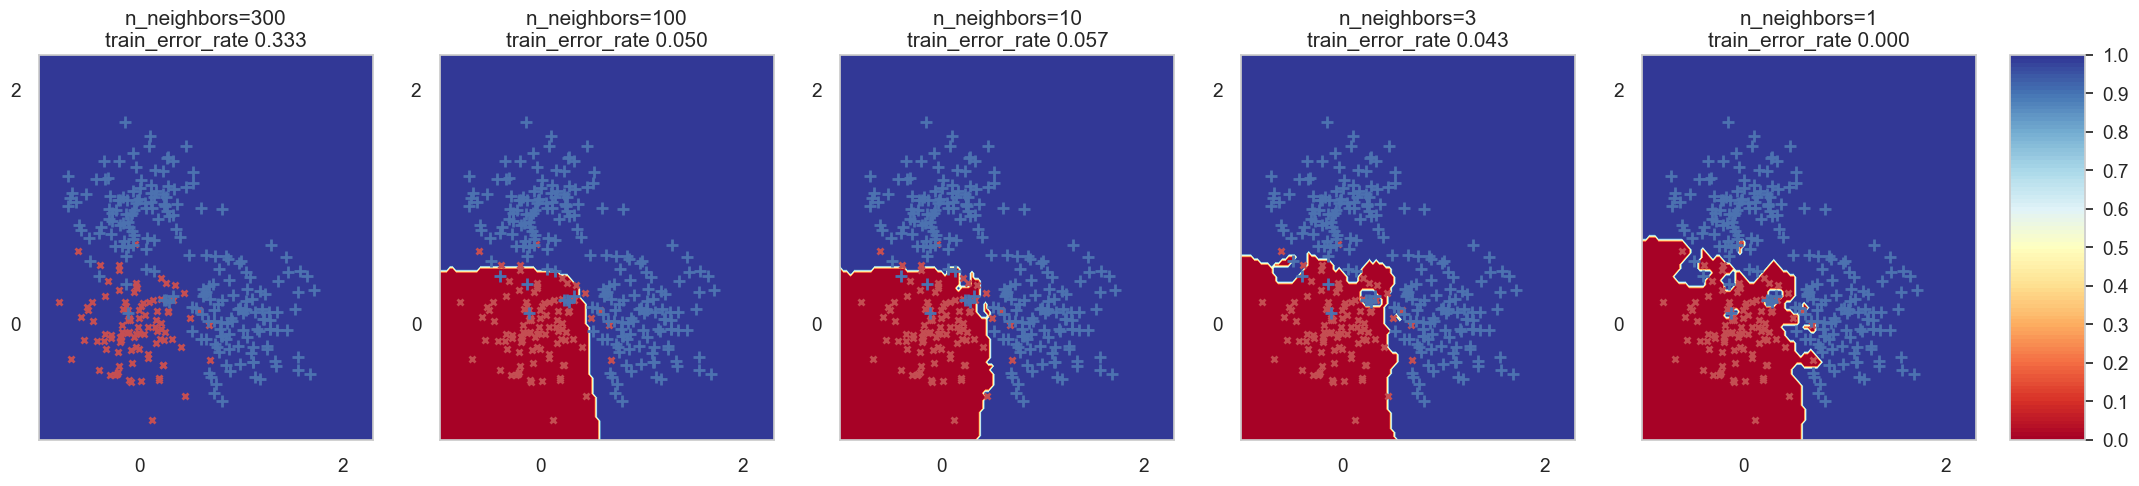

In [ ]:
n_neighbors_grid = [y_N.size, 100, 10, 3,  1]
ncols = len(n_neighbors_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, n_neighbors in enumerate(n_neighbors_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='brute')
    clf.fit(x_N2, y_N)
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("n_neighbors=%d\ntrain_error_rate %.3f" % (n_neighbors, err_rate))

<a id="part6"></a>

### Discussion 4a: Why does the KNN classifier get zero training error on the training set? Would we expect this on the validation set?

### Discussion 4b: How could you select the number of neighbors to use for this classifier?

<a id="part5"></a>

# Part 5: Visualization of Logistic Regression predictions as we vary C

Remember, C controls the *strength* of the L2 penalty on weight parameters.

* Large C means almost no penalty.
* Small C means all weights are close to zero.

C =  0.0001 Learned weights + intercept
[0.00350077 0.00359405 0.69089925]
C =   0.01 Learned weights + intercept
[0.30415754 0.31704215 0.50303902]
C =      1 Learned weights + intercept
[ 3.69909509  4.09481524 -1.13513711]
C =  1e+02 Learned weights + intercept
[ 6.35208109  7.0858374  -2.22095481]
C =  1e+06 Learned weights + intercept
[ 6.44660853  7.19201879 -2.25875422]


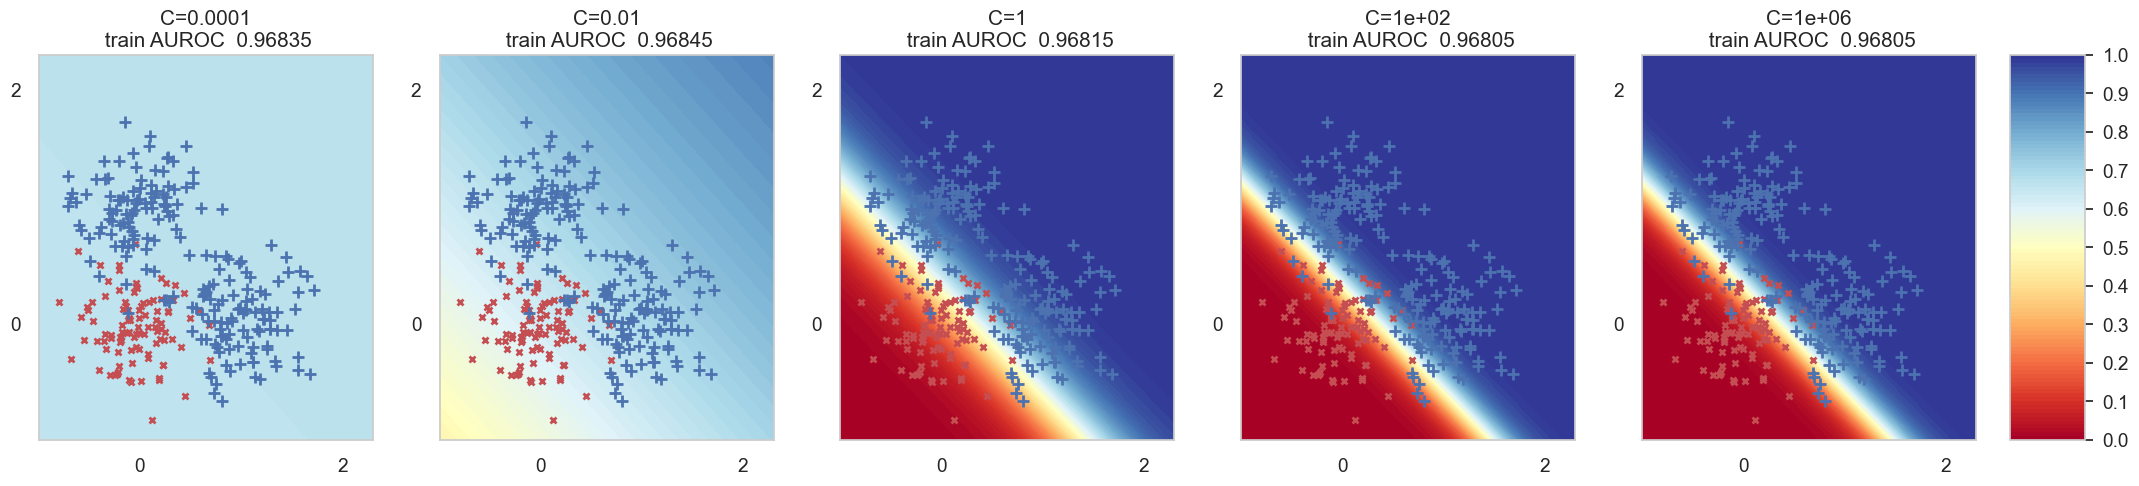

In [ ]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 1000000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)
    auroc = sklearn.metrics.roc_auc_score(y_N, clf.predict_proba(x_N2)[:,1])

    plot_pretty_probabilities_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g\n train AUROC % .5f" % (C, auroc))
    
    print("C = % 6.2g Learned weights + intercept" % C)
    print(np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)]))

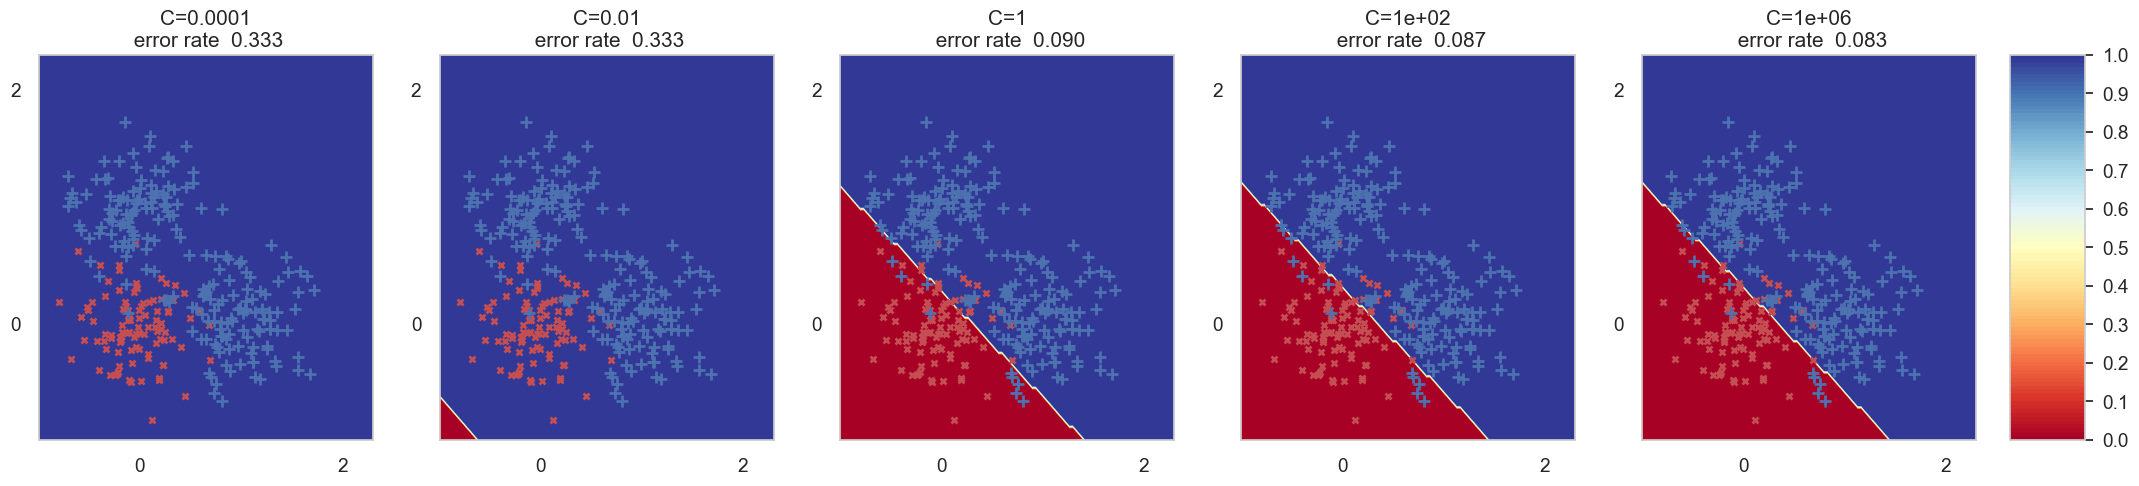

In [ ]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 1000000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_N2, y_N)    
    err_rate = np.mean(np.logical_xor(y_N, clf.predict(x_N2)))
    
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_N2, y_N);
    
    plt.title("C=%.2g\n error rate % .3f" % (C, err_rate))
    

### Challenge Exercise 5a: Why does the decision boundary look like a line? Can you justify why it is linear with math?

Remember:

$$
p( y_n = 1 | x_n) = \sigma( w^T x_n + b )
$$

### Challenge Exercise 5b: Given the learned weights and intercept below, can you find the equation for the decision line?

In [ ]:
clf.coef_

array([[6.44660853, 7.19201879]])

In [ ]:
clf.intercept_

array([-2.25875422])